In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive/Classroom/Spring2020-Deep\ Learning/Assignments/Assignment5-2

/content/drive/My Drive/Classroom/Spring2020-Deep Learning/Assignments/Assignment5-2


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm
from sklearn.metrics import multilabel_confusion_matrix, f1_score, classification_report
import pandas as pd

In [0]:
phases = ['Train', 'Validation', 'Test']

In [0]:
data_transforms = {
    phases[0] : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    phases[1]: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    phases[2]: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
data_dir = 'A_05_Part_02_Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in phases}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets[phases[0]].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

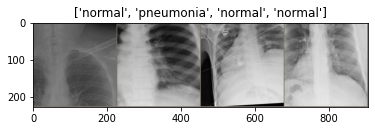

In [0]:
inputs, classes = next(iter(dataloaders[phases[0]]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, focal_loss=False, alpha=0.25, gamma=2):
    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    validation_loss = []
    train_acc = []
    validation_acc = []
    for epoch in range(num_epochs):

        for phase in phases[:2]:

            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0

            progress_bar = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]))

            for i, data in progress_bar:

                inputs, labels = data
                one_hot_labels = F.one_hot(labels, len(class_names)).to(torch.float64)
                inputs, one_hot_labels, labels = inputs.to(device), one_hot_labels.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    loss = criterion(outputs, one_hot_labels)

                    if focal_loss:
                        loss = alpha * ((1 - torch.exp(-loss)).pow(gamma)) * loss

                    if(phase == 'Train'):
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                
                progress_bar.set_description(f'{phase} Epoch: {epoch}')
                
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] * 100

            if phase == 'Train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                validation_loss.append(epoch_loss)
                validation_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
        print()
    
    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)

    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.legend(["Train Loss", "Validation Loss"])
    plt.show()

    plt.plot(train_acc)
    plt.plot(validation_acc)
    plt.legend(['Train Accuracy', 'Validation Accuracy'])
    plt.show()

    return model

In [0]:
def visualize_model(model, phase, num_images=6):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                    
        model.train(mode=was_training)

In [0]:
def plot_confusion_matrix(y_true, y_pred, labels, phase):
    cm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    
    print(cm)

    for i in range(len(cm)):

        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[i])
        plt.title(f'Confusion matrix of {phase} data')
        fig.colorbar(cax)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [0]:
def accuracy(model, phase):

    correct = 0
    total = 0
    num_classes = len(class_names)

    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in dataloaders[phase]:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predicted_labels.append(predicted)
            actual_labels.append(labels)
        
        print(f'Accuracy of the network on {len(dataloaders[phase].dataset)} {phase} images: {(100 * correct / total):.4f}%')

        predicted_labels = list(np.concatenate([x.cpu().numpy() for x in predicted_labels]))
        actual_labels = list(np.concatenate([x.cpu().numpy() for x in actual_labels]))

        print(f"F1 Score for {phase} data = {f1_score(actual_labels, predicted_labels, [0, 1, 2], average='micro'):.4f}")

        print(classification_report(actual_labels, predicted_labels))
        plot_confusion_matrix(actual_labels, predicted_labels, [0, 1, 2], phase)

# Resnet Without Focal Loss


Train Loss: 0.3380 Acc: 78.3065



Validation Loss: 0.1967 Acc: 89.1720




Train Loss: 0.2842 Acc: 83.3710



Validation Loss: 0.1776 Acc: 90.9236




Train Loss: 0.2766 Acc: 84.4516



Validation Loss: 0.1606 Acc: 92.3567




Train Loss: 0.2667 Acc: 85.0484



Validation Loss: 0.1336 Acc: 93.3121




Train Loss: 0.2388 Acc: 86.7742



Validation Loss: 0.1319 Acc: 92.9936




Train Loss: 0.2427 Acc: 86.7258



Validation Loss: 0.1186 Acc: 94.9045




Train Loss: 0.2369 Acc: 87.2097



Validation Loss: 0.1217 Acc: 94.9045




Train Loss: 0.2016 Acc: 89.8871



Validation Loss: 0.1023 Acc: 95.2229




Train Loss: 0.1993 Acc: 89.9677



Validation Loss: 0.0975 Acc: 95.7006




Train Loss: 0.1888 Acc: 90.8710



Validation Loss: 0.1073 Acc: 94.4268

Training complete in 24m 17s
Best val Acc: 95.700637


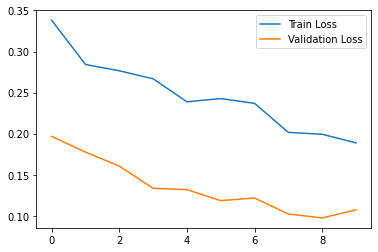

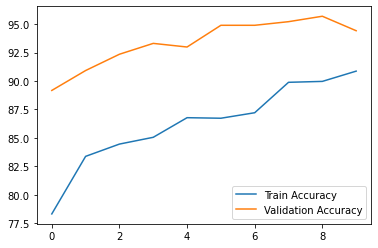

In [0]:
model_resnet = models.resnet18(pretrained=True)

in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, len(class_names))
model_resnet = model_resnet.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

torch.save(model_resnet.state_dict(), 'res18.pth')

Accuracy of the network on 6200 Train images: 89.5000%
F1 Score for Train data = 0.8950
              precision    recall  f1-score   support

           0       0.78      0.41      0.54       200
           1       0.91      0.95      0.93      4000
           2       0.87      0.83      0.85      2000

    accuracy                           0.90      6200
   macro avg       0.85      0.73      0.77      6200
weighted avg       0.89      0.90      0.89      6200

[[[5977   23]
  [ 117   83]]

 [[1831  369]
  [ 198 3802]]

 [[3941  259]
  [ 336 1664]]]


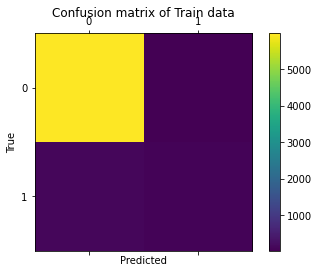

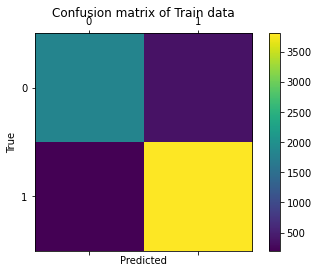

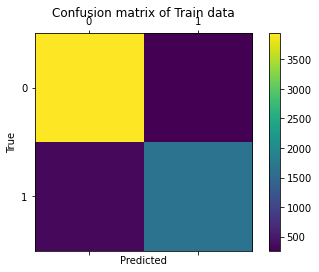

Accuracy of the network on 628 Validation images: 92.5159%
F1 Score for Validation data = 0.9252
              precision    recall  f1-score   support

           0       0.93      0.50      0.65        28
           1       0.93      0.96      0.95       400
           2       0.92      0.91      0.91       200

    accuracy                           0.93       628
   macro avg       0.93      0.79      0.84       628
weighted avg       0.93      0.93      0.92       628

[[[599   1]
  [ 14  14]]

 [[198  30]
  [ 14 386]]

 [[412  16]
  [ 19 181]]]


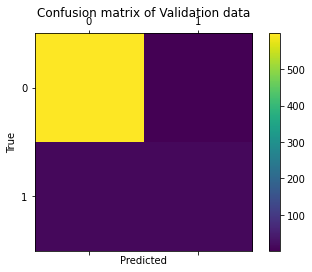

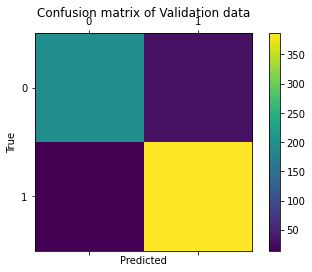

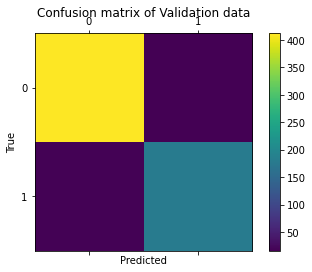

In [30]:
model_resnet.load_state_dict(torch.load('res18.pth'))

for phase in phases[:2]:
    accuracy(model_resnet, phase)

# Resnet With Focal Loss


Train Loss: 0.0137 Acc: 73.4677



Validation Loss: 0.0081 Acc: 84.7134




Train Loss: 0.0101 Acc: 80.1452



Validation Loss: 0.0069 Acc: 85.0318




Train Loss: 0.0096 Acc: 80.5645



Validation Loss: 0.0060 Acc: 86.4650




Train Loss: 0.0086 Acc: 82.4516



Validation Loss: 0.0056 Acc: 88.5350




Train Loss: 0.0085 Acc: 81.8710



Validation Loss: 0.0049 Acc: 88.5350




Train Loss: 0.0083 Acc: 82.1613



Validation Loss: 0.0044 Acc: 89.1720




Train Loss: 0.0080 Acc: 82.4677



Validation Loss: 0.0038 Acc: 89.8089




Train Loss: 0.0080 Acc: 82.7258



Validation Loss: 0.0041 Acc: 89.3312




Train Loss: 0.0079 Acc: 83.1613



Validation Loss: 0.0038 Acc: 89.6497




Train Loss: 0.0075 Acc: 83.5323



Validation Loss: 0.0048 Acc: 86.9427

Training complete in 24m 23s
Best val Acc: 89.808917


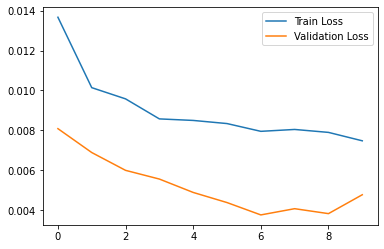

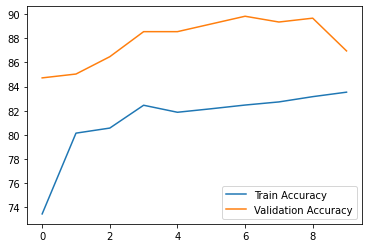

In [0]:
model_resnet = models.resnet18(pretrained=True)

in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, len(class_names))

model_resnet = model_resnet.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10, focal_loss=True)

torch.save(model_resnet.state_dict(), 'res18_focal_loss.pth')

Accuracy of the network on 6200 Train images: 82.1935%
F1 Score for Train data = 0.8219
              precision    recall  f1-score   support

           0       0.86      0.06      0.11       200
           1       0.84      0.92      0.88      4000
           2       0.77      0.70      0.73      2000

    accuracy                           0.82      6200
   macro avg       0.82      0.56      0.58      6200
weighted avg       0.82      0.82      0.81      6200

[[[5998    2]
  [ 188   12]]

 [[1522  678]
  [ 322 3678]]

 [[3776  424]
  [ 594 1406]]]


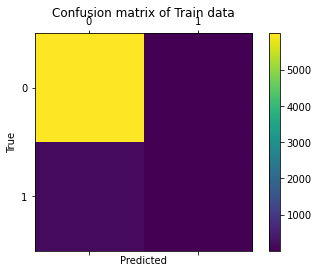

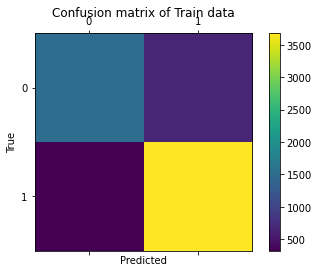

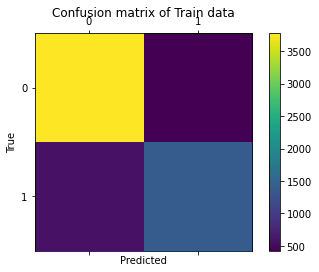

Accuracy of the network on 628 Validation images: 86.4650%
F1 Score for Validation data = 0.8646
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        28
           1       0.88      0.94      0.91       400
           2       0.83      0.83      0.83       200

    accuracy                           0.86       628
   macro avg       0.90      0.60      0.60       628
weighted avg       0.87      0.86      0.85       628

[[[600   0]
  [ 27   1]]

 [[178  50]
  [ 24 376]]

 [[393  35]
  [ 34 166]]]


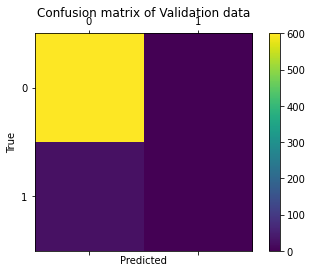

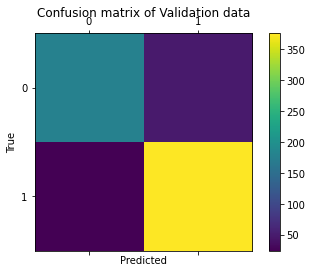

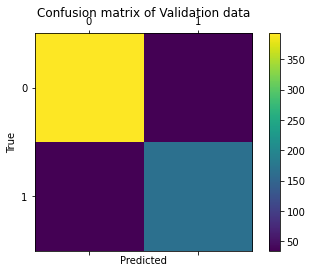

In [31]:
model_resnet.load_state_dict(torch.load('res18_focal_loss.pth'))

for phase in phases[:2]:
    accuracy(model_resnet, phase)

# VGG Without Focal Loss

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Train Loss: 0.2895 Acc: 82.9355



Validation Loss: 0.1850 Acc: 90.2866




Train Loss: 0.2311 Acc: 86.7903



Validation Loss: 0.1584 Acc: 89.9682




Train Loss: 0.2136 Acc: 87.9516



Validation Loss: 0.1470 Acc: 92.5159




Train Loss: 0.1948 Acc: 89.3387



Validation Loss: 0.1645 Acc: 92.5159




Train Loss: 0.1949 Acc: 89.0161



Validation Loss: 0.1335 Acc: 93.1529




Train Loss: 0.1884 Acc: 89.4516



Validation Loss: 0.1352 Acc: 92.9936




Train Loss: 0.1812 Acc: 90.3226



Validation Loss: 0.1212 Acc: 93.4713




Train Loss: 0.1490 Acc: 91.6613



Validation Loss: 0.1037 Acc: 94.5860




Train Loss: 0.1385 Acc: 92.4839



Validation Loss: 0.1022 Acc: 94.4268




Train Loss: 0.1379 Acc: 92.4194



Validation Loss: 0.0958 Acc: 95.0637

Training complete in 80m 12s
Best val Acc: 95.063694


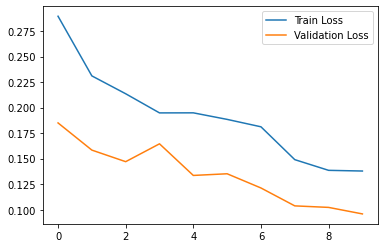

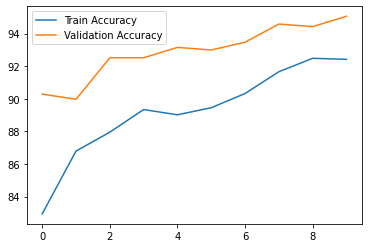

In [0]:
model_vgg = models.vgg16(pretrained=True)

in_features = model_vgg.classifier[6].in_features

features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, len(class_names))])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

torch.save(model_vgg.state_dict(), 'vgg16.pth')

Accuracy of the network on 6200 Train images: 92.2581%
F1 Score for Train data = 0.9226
              precision    recall  f1-score   support

           0       0.76      0.56      0.65       200
           1       0.92      0.98      0.95      4000
           2       0.93      0.84      0.89      2000

    accuracy                           0.92      6200
   macro avg       0.87      0.79      0.83      6200
weighted avg       0.92      0.92      0.92      6200

[[[5965   35]
  [  88  112]]

 [[1878  322]
  [  80 3920]]

 [[4077  123]
  [ 312 1688]]]


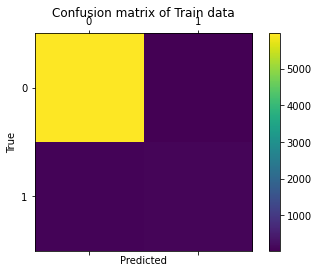

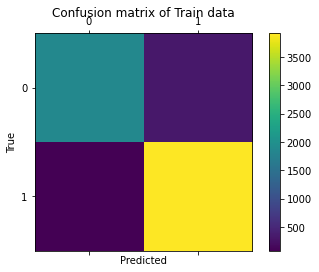

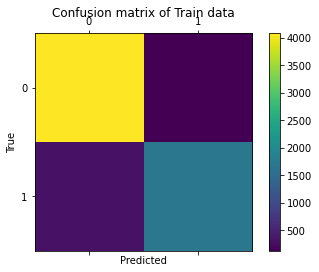

Accuracy of the network on 628 Validation images: 95.2229%
F1 Score for Validation data = 0.9522
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.95      0.99      0.97       400
           2       0.97      0.92      0.94       200

    accuracy                           0.95       628
   macro avg       0.93      0.85      0.88       628
weighted avg       0.95      0.95      0.95       628

[[[597   3]
  [ 10  18]]

 [[207  21]
  [  4 396]]

 [[422   6]
  [ 16 184]]]


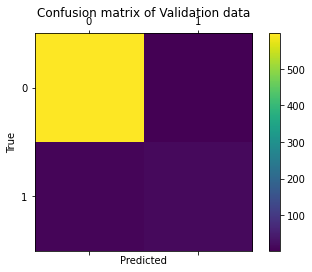

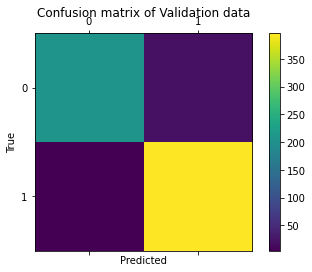

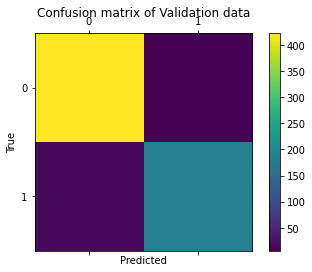

In [32]:
model_vgg.load_state_dict(torch.load('vgg16.pth'))

for phase in phases[:2]:
    accuracy(model_vgg, phase)

# VGG With Focal Loss


Train Loss: 0.0099 Acc: 81.1613



Validation Loss: 0.0075 Acc: 81.6879




Train Loss: 0.0065 Acc: 86.3548



Validation Loss: 0.0041 Acc: 89.4904




Train Loss: 0.0053 Acc: 87.3548



Validation Loss: 0.0039 Acc: 90.1274




Train Loss: 0.0053 Acc: 87.7903



Validation Loss: 0.0036 Acc: 90.2866




Train Loss: 0.0047 Acc: 88.4516



Validation Loss: 0.0037 Acc: 90.4459




Train Loss: 0.0047 Acc: 88.8710



Validation Loss: 0.0033 Acc: 91.0828




Train Loss: 0.0042 Acc: 89.3226



Validation Loss: 0.0049 Acc: 90.6051




Train Loss: 0.0042 Acc: 89.2419



Validation Loss: 0.0032 Acc: 91.7197




Train Loss: 0.0039 Acc: 89.8548



Validation Loss: 0.0028 Acc: 91.5605




Train Loss: 0.0041 Acc: 89.4516



Validation Loss: 0.0031 Acc: 91.8790

Training complete in 80m 59s
Best val Acc: 91.878981


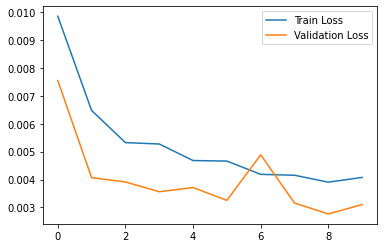

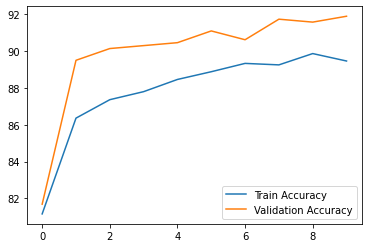

In [0]:
model_vgg = models.vgg16(pretrained=True)

in_features = model_vgg.classifier[6].in_features

features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, len(class_names))])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10, focal_loss=True)

torch.save(model_vgg.state_dict(), 'vgg16_focal_loss.pth')

Accuracy of the network on 6200 Train images: 89.3387%
F1 Score for Train data = 0.8934
              precision    recall  f1-score   support

           0       0.78      0.21      0.34       200
           1       0.92      0.94      0.93      4000
           2       0.84      0.86      0.85      2000

    accuracy                           0.89      6200
   macro avg       0.85      0.67      0.71      6200
weighted avg       0.89      0.89      0.89      6200

[[[5988   12]
  [ 157   43]]

 [[1868  332]
  [ 221 3779]]

 [[3883  317]
  [ 283 1717]]]


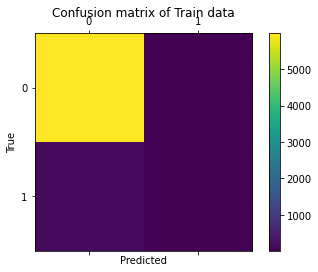

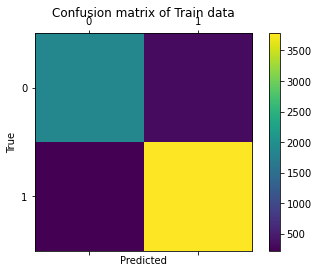

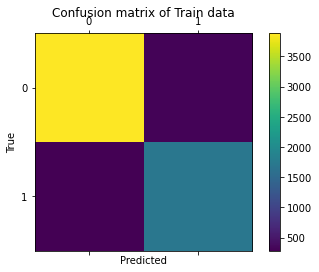

Accuracy of the network on 628 Validation images: 91.0828%
F1 Score for Validation data = 0.9108
              precision    recall  f1-score   support

           0       0.80      0.14      0.24        28
           1       0.92      0.97      0.95       400
           2       0.89      0.90      0.89       200

    accuracy                           0.91       628
   macro avg       0.87      0.67      0.69       628
weighted avg       0.91      0.91      0.90       628

[[[599   1]
  [ 24   4]]

 [[196  32]
  [ 12 388]]

 [[405  23]
  [ 20 180]]]


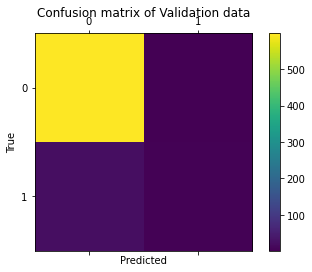

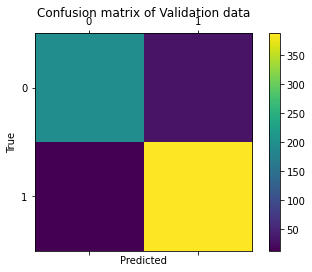

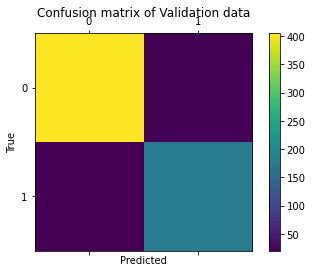

In [33]:
model_vgg.load_state_dict(torch.load('vgg16_focal_loss.pth'))

for phase in phases[:2]:
    accuracy(model_vgg, phase)

In [0]:
model_vgg.load_state_dict(torch.load('vgg16_focal_loss.pth'))
model = model_vgg
model.to(device)

predicted_values = []

filenames = dataloaders['Test'].dataset.samples

filenames = [os.path.basename(x[0]) for x in filenames]

index = 0

for data in dataloaders['Test']:

    inputs, _ = data
    inputs = inputs.to(device)


    
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    outputs[outputs >= 0.5] = 1
    outputs[outputs < 0.5] = 0

    outputs = outputs.index_select(1, torch.tensor([0, 2, 1]).cuda())

    for i in range(len(outputs)):

        predicted = []

        predicted.append(filenames[index])

        predicted.append(int(outputs[i][0].item()))
        predicted.append(int(outputs[i][1].item()))
        predicted.append(int(outputs[i][2].item()))

        index += 1

        predicted_values.append(predicted)

df = pd.DataFrame(predicted_values)
df.to_csv('MSCS18013_results.csv', index=False, header=False)